In [1]:
import requests
from bs4 import BeautifulSoup
import time
import pandas as pd
import sqlite3 as lite
import os
import sys
#from matplotlib import pyplot as plt
import numpy as np
import statsmodels.api as sm
#%matplotlib inline
from collections import Counter
import itertools

In [2]:
headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/43.0.2357.124 Safari/537.36'}

In [3]:
cities = [['tx', "austin"] ,[ 'ca' , 'los-angeles'] ,[ 'ga' , 'atlanta'] ,[ 'ma' , 'boston'] ,[ 'nc' , 'charlotte'] ,[ 'tx' , 'dallas'] ,[ 'co' , 'denver'] ,[ 'tx' , 'houston'] ,[ 'fl' , 'miami'] ,[ 'mn' , 'minneapolis'] ,[ 'ny' , 'new-york'] ,[ 'pa' , 'philadelphia'] ,[ 'az' , 'phoenix'] ,[ 'or' , 'portland'] ,[ 'ca' , 'san-francisco'] ,[ 'ca' , 'san-diego'] ,[ 'wa' , 'seattle'] ,[ 'dc' , 'washington'] ]

In [4]:
# CRAWL ALL THE PAGES OF INTEREST
datadir = 'crawl/'
if not(os.path.isdir(datadir)):
    os.makedirs(datadir)

for city in cities:
    k = city[0]
    v = city[1]
    running = True
    page = 1
    print ''
    print k,v
    while running:
        url = "https://dogvacay.com/dog-boarding--" + k + "--" + v + "?p="+str(page)
        filename = datadir + k + '-' + v + '-' + str(page) + '.htm'
        if not(os.path.isfile(filename)):
            sys.stdout.write('-')
            r = requests.get(url, headers=headers)
            time.sleep(1)
            f = open(filename, 'w')
            f.write(r.text.encode('ascii', 'replace'))
            f.close()
            data = r.text
        else:
            sys.stdout.write('.')
            f = open(filename, 'r')
            data = f.read()
            f.close()
        soup = BeautifulSoup(data)
        pagination_links = soup.findAll('a', {'class': 'pagination-link'})
        running = False
        for pl in pagination_links:
            if pl.text.find('Next') == 0:
                running = True
        page+=1



tx austin
...............
ca los-angeles
..................................................................................
ga atlanta
....................
ma boston
......................
nc charlotte
.............
tx dallas
.................
co denver
.......................
tx houston
........................
fl miami
....................
mn minneapolis
............
ny new-york
..................................................................................................................
pa philadelphia
.....................
az phoenix
...............
or portland
..................
ca san-francisco
...................................
ca san-diego
......................
wa seattle
................
dc washington
..............................................

In [5]:
# Data extraction phase

times = []
fees = []
reviews = []
repeats = []
city = []
service = []
rating = []
name = []


for src in os.listdir(datadir):
    filename = datadir + src
    print 'Processing: ' + filename
    f = open(filename, 'r')
    data = f.read()
    f.close()
    soup = BeautifulSoup(data)
    sitters = soup.findAll(lambda tag:tag.name == "div" and \
                           len(tag.attrs) == 1 and \
                           tag.attrs.keys()[0] == "search-list-item")
    for sitter in sitters:
        rtwrap = sitter.findAll('li', {'class': 'dv-search-badge-item'})
        if len(rtwrap) > 0:
            response_time = rtwrap[0].text.strip('\n')[18:]
        else:
            response_time = -1
        fee = sitter.findAll('span', {'class': "dv-host-list-item__price__amount"})[0].text.strip()[1:4]
        review = sitter.find('span', {'class': 'dv-host-review'})
        if review is not None and len(review) > 0:
            review = int(review.text.replace('Reviews', '').replace('Review', '').strip())
        else:
            review = 0
        rpwrap = sitter.findAll('span', {'class': 'dv-host-repeat'})
        if len(rpwrap) == 1: # and len(repeat.strip()) > 12:
            repeat = rpwrap[0].text.strip()[:1]
        else:
            repeat = 0
        names = sitter.find('a', {'class': 'dv-host-list-item__body__link'}).text#.strip('\n$').split(' ')
        services = sitter.findAll('div', {'class': 'dv-host-list-item__info dv-host-list-item__services'})[0].text.strip('\n')
        full_star = sitter.findAll('i', {'class':" dv-icon dv-icon__star "})
        ratings = len(full_star)
        half_star = sitter.findAll('i', {'class': " dv-icon dv-icon__star-half "})
        if len(half_star) > 0:
            ratings += .5
        title = soup.find('title').text
        i = title.find(' Dog Boarding')
        title = title[0:i]
        times.append(response_time)
        fees.append(fee)#.strip()#'\n$')#[:1]#[0].text
        reviews.append(review)
        repeats.append(repeat)
        city.append(title)
        name.append(names)
        rating.append(ratings)
        service.append(services)#.text.strip('\n'))
df = pd.DataFrame({'ratings': rating, 'services' : service, 'names': name, 'title':city, 'response_time': times, 'fee':fees, 'review':reviews,'repeat':repeats})

Processing: crawl/az-phoenix-1.htm
Processing: crawl/az-phoenix-10.htm
Processing: crawl/az-phoenix-11.htm
Processing: crawl/az-phoenix-12.htm
Processing: crawl/az-phoenix-13.htm
Processing: crawl/az-phoenix-14.htm
Processing: crawl/az-phoenix-15.htm
Processing: crawl/az-phoenix-2.htm
Processing: crawl/az-phoenix-3.htm
Processing: crawl/az-phoenix-4.htm
Processing: crawl/az-phoenix-5.htm
Processing: crawl/az-phoenix-6.htm
Processing: crawl/az-phoenix-7.htm
Processing: crawl/az-phoenix-8.htm
Processing: crawl/az-phoenix-9.htm
Processing: crawl/ca-los-angeles-1.htm
Processing: crawl/ca-los-angeles-10.htm
Processing: crawl/ca-los-angeles-11.htm
Processing: crawl/ca-los-angeles-12.htm
Processing: crawl/ca-los-angeles-13.htm
Processing: crawl/ca-los-angeles-14.htm
Processing: crawl/ca-los-angeles-15.htm
Processing: crawl/ca-los-angeles-16.htm
Processing: crawl/ca-los-angeles-17.htm
Processing: crawl/ca-los-angeles-18.htm
Processing: crawl/ca-los-angeles-19.htm
Processing: crawl/ca-los-angel

In [6]:
df.head()

,fee,names,ratings,repeat,response_time,review,services,title
0,25,patricia's pet heaven,4.5,9,Few Hours,11,Boarding ...,"Phoenix, Arizona"
1,35,**DOGGIE BED & BARKFEST**,5.0,1,Day,45,"Boarding, ...","Phoenix, Arizona"
2,20,Doggie Heaven,5.0,1,Few Days,28,"Boarding, ...","Phoenix, Arizona"
3,25,Stay at home mother and dog lover!,5.0,5,Day,6,"Boarding, ...","Phoenix, Arizona"
4,20,Kelrey's Doggy Dream Stay,4.5,3,Few Hours,3,"Boarding, ...","Phoenix, Arizona"


In [12]:
#eliminate trailing spaces from response_time
df['response_time'] = df['response_time'].apply(lambda x: str(x).strip())

In [13]:
#separate services
df['boarding'] = df['services'].map(lambda x: 1 if "Boarding" in x else 0)
df['sitting'] = df['services'].map(lambda x: 1 if "Sitting" in x else 0)
df['daycare'] = df['services'].map(lambda x: 1 if "Daycare" in x else 0)
df['checkups'] = df['services'].map(lambda x: 1 if "Checkups and Visits" in x else 0)
df['walking'] = df['services'].map(lambda x: 1 if "Walking" in x else 0)
df['bathing'] = df['services'].map(lambda x: 1 if "Bathing" in x else 0)
df['training'] = df['services'].map(lambda x: 1 if "Training" in x else 0)
df['grooming'] = df['services'].map(lambda x: 1 if "Grooming" in x else 0)
df['pickup/dropoff'] = df['services'].map(lambda x: 1 if "Pick up and Drop off" in x else 0)

In [14]:
#response time
df['response_time'] = df['response_time'].map(lambda x: 1 if x == 'Few Hours' else 2 if x == 'Day' else 3)

In [15]:
df.ix[df['fee']=='', 'fee'] = 0

In [16]:
df["fee"] = df["fee"].astype(float)
df["repeat"] = df["repeat"].astype(int)

In [17]:
df['services'] = df['boarding']+df['sitting']+df['daycare']+df['checkups']+df['walking']+df['bathing']+df['training']+df['grooming']+df['pickup/dropoff']

In [18]:
df.head()

,fee,names,ratings,repeat,response_time,review,services,title,boarding,sitting,daycare,checkups,walking,bathing,training,grooming,pickup/dropoff
0,25,patricia's pet heaven,4.5,9,1,11,1,"Phoenix, Arizona",1,0,0,0,0,0,0,0,0
1,35,**DOGGIE BED & BARKFEST**,5.0,1,2,45,3,"Phoenix, Arizona",1,0,1,0,0,1,0,0,0
2,20,Doggie Heaven,5.0,1,3,28,4,"Phoenix, Arizona",1,1,1,1,0,0,0,0,0
3,25,Stay at home mother and dog lover!,5.0,5,2,6,4,"Phoenix, Arizona",1,0,1,1,1,0,0,0,0
4,20,Kelrey's Doggy Dream Stay,4.5,3,1,3,4,"Phoenix, Arizona",1,0,1,0,0,1,0,0,1


In [19]:
# SAVE TO CSV FILE
df.to_csv('dog-vacay.csv', encoding='ascii')

In [29]:
#Create a scatter plot matrix
a = pd.scatter_matrix(df, alpha=.05, figsize=(10,10))
plt.show()

RuntimeError: Python is not installed as a framework. The Mac OS X backend will not be able to function correctly if Python is not installed as a framework. See the Python documentation for more information on installing Python as a framework on Mac OS X. Please either reinstall Python as a framework, or try one of the other backends. If you are Working with Matplotlib in a virtual enviroment see 'Working with Matplotlib in Virtual environments' in the Matplotlib FAQ

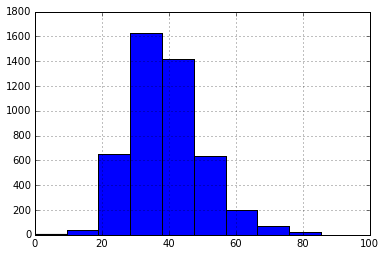

In [16]:
#Histogram of fees
p = df['fee'].hist()
plt.show()

In [30]:
#Extract columns
fee = df['fee']
repeat = df['repeat']
ratings = df['ratings']

In [31]:
#The dependent variable
y = np.matrix(fee).transpose()
#The independent variable
x1 = np.matrix(repeat).transpose()
x2 = np.matrix(rating).transpose()

In [32]:
x = np.column_stack([x1, x2])

In [33]:
X = sm.add_constant(x)
model = sm.OLS(y,X)
f = model.fit()
f.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     3.939
Date:                Sun, 20 Mar 2016   Prob (F-statistic):             0.0195
Time:                        16:03:59   Log-Likelihood:                -24694.
No. Observations:                6162   AIC:                         4.939e+04
Df Residuals:                    6159   BIC:                         4.941e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         37.9596      0.265    143.090      0.000        37.440    38.480
x1             0.0682      0.097      0.706      0.480        -0.121     0.258
x2            -0.2177      0.081     -2.693      0.007        -0.376    -0.059
==============================================================================
Omnibus:                     7881.923   Durbin-Watson:                   1.685
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          6435303.096
Skew:                           6.424   Prob(JB):                         0.00
Kurtosis:                     160.795   Cond. No.                         6.88
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [38]:
#df.groupby('repeat').mean()

In [37]:
#df.groupby('repeat').median()

In [123]:
#df.groupby('services').median()

In [122]:
#df.groupby('services').mean()

In [117]:
#df.groupby('review').median()

In [118]:
#atx.groupby('review').median()

In [119]:
#sea.groupby('review').median()

In [183]:
#df.groupby('city').mean()

In [184]:
#df.groupby('city').median()